In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from helper_functions import *

N_SAMPLES = 1000
NUM_CLASSES = 10
NUM_FEATURES = 10
RANDOM_SEED = 42

print(f"Torch: version {torch.__version__}")
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
!nvidia-smi

Torch: version 2.7.1
zsh:1: command not found: nvidia-smi


In [25]:
# Multiclass Classification

In [26]:
# Create the dataset
X_blob, y_blob = make_blobs(n_samples=N_SAMPLES,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=.2,
                            random_state=RANDOM_SEED)

In [27]:
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

In [28]:
X_blob, y_blob

(tensor([[ 5.6013, -6.2080, -9.8935,  ..., -8.3133, -3.1895, -7.5747],
         [ 9.5642,  5.1637,  8.9540,  ..., -6.1516, -9.0735, -3.5767],
         [ 1.9815, -6.3396, -8.5431,  ..., -7.6643,  3.4286, -1.1591],
         ...,
         [ 2.2972, -6.4714, -8.7274,  ..., -7.8825,  3.6717, -1.1824],
         [ 5.6001, -6.1225, -9.6421,  ..., -8.3148, -3.0419, -7.8926],
         [ 2.2615, -6.6992, -8.3143,  ..., -7.8963,  3.2716, -1.1913]]),
 tensor([7., 5., 3., 4., 1., 5., 5., 0., 2., 0., 1., 7., 6., 8., 8., 1., 0., 9.,
         9., 6., 1., 9., 2., 9., 0., 7., 1., 3., 1., 2., 2., 2., 0., 9., 5., 7.,
         8., 4., 5., 0., 6., 1., 7., 3., 1., 1., 4., 0., 5., 2., 6., 2., 1., 2.,
         9., 3., 9., 5., 6., 0., 4., 8., 4., 6., 5., 8., 1., 8., 1., 3., 5., 5.,
         0., 3., 3., 3., 8., 8., 4., 8., 5., 6., 2., 4., 7., 0., 3., 3., 6., 2.,
         9., 4., 4., 7., 8., 2., 5., 5., 2., 1., 2., 6., 5., 4., 2., 8., 6., 1.,
         9., 7., 2., 3., 2., 5., 2., 0., 2., 7., 0., 7., 4., 8., 8., 9.,

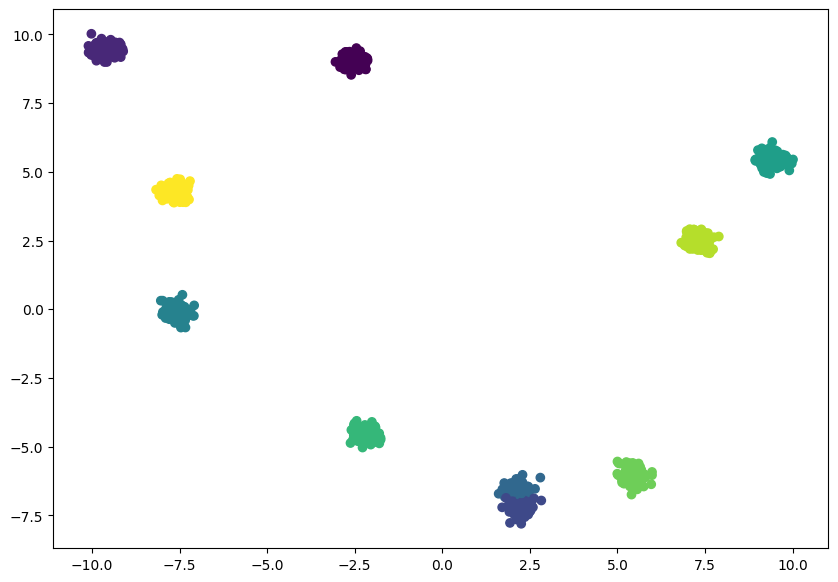

In [29]:
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c = y_blob)

In [30]:
# Lets build the model
class MultiClass(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(2, 4)        

    def forward(self, x : torch.tensor):
        self.l1(x)

model = MultiClass()


Ep: 0 | loss: 0.77073 | tloss: 0.76094 | tacc: 54.78787878787878 
Ep: 100 | loss: 0.28611 | tloss: 0.29216 | tacc: 90.0 
Ep: 200 | loss: 0.22616 | tloss: 0.23147 | tacc: 90.0 
Ep: 300 | loss: 0.18051 | tloss: 0.18540 | tacc: 90.93939393939394 
Ep: 400 | loss: 0.14526 | tloss: 0.14945 | tacc: 92.84848484848484 
Ep: 500 | loss: 0.11834 | tloss: 0.12168 | tacc: 96.6969696969697 
Ep: 600 | loss: 0.09729 | tloss: 0.09990 | tacc: 96.63636363636364 
Ep: 700 | loss: 0.07965 | tloss: 0.08174 | tacc: 98.60606060606061 
Ep: 800 | loss: 0.06460 | tloss: 0.06634 | tacc: 98.96969696969697 
Ep: 900 | loss: 0.05175 | tloss: 0.05321 | tacc: 100.0 


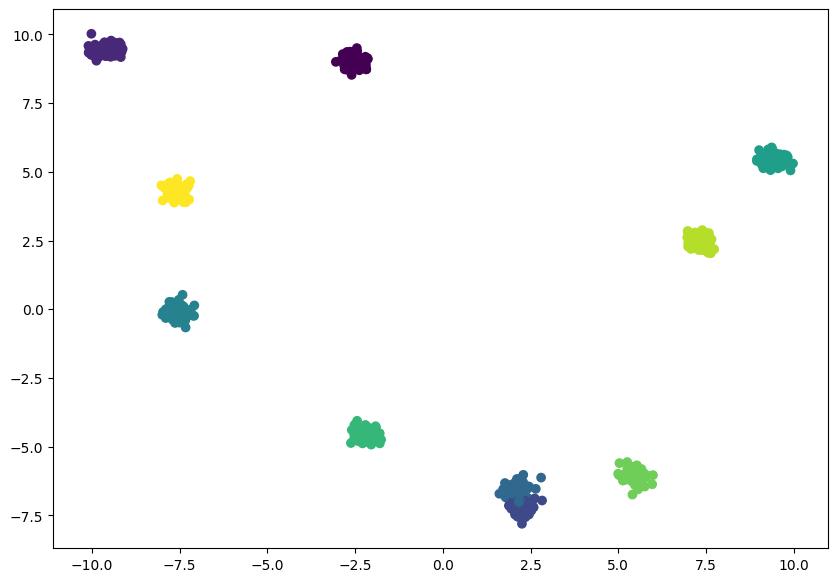

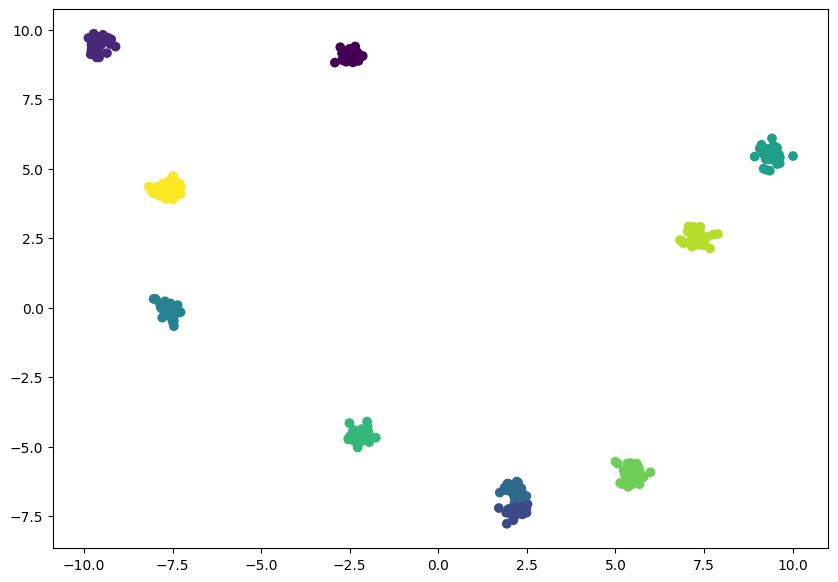

In [41]:
def printClass(X_, y_, n_classes):
    y_train_blob = torch.zeros(len(y_))
    for i in range(len(y_train_blob)):
        for c in range(n_classes):
            if int(y_[i][c].item()) == 1:
                y_train_blob[i] = c

    plt.figure(figsize=(10, 7))
    plt.scatter(X_[:, 0], X_[:, 1], c = y_train_blob)

# Calculate accuracy - out of 100 what percent the model gets right
def accuracy_fn(y_test, preds):
    correct = torch.sum(torch.eq(y_test, preds).type(torch.int))
    return  correct.item() / len(y_test) * 10

y = torch.zeros(N_SAMPLES, NUM_CLASSES)
for i in range(len(y_blob)):
    y[i][int(y_blob[i].item())] = 1

# Model with non linearity
model = nn.Sequential(
    nn.Linear(NUM_FEATURES, 8),
    nn.ReLU(),
    nn.Linear(8, 8),
    nn.Linear(8, NUM_CLASSES),
)

X_train, X_test, y_train, y_test = train_test_split(X_blob, y, test_size=0.33, random_state=432)
X_train, X_test, y_train, y_test

printClass(X_train, y_train, NUM_CLASSES)

# Training
# Loss for classification
loss_fn = nn.MultiLabelSoftMarginLoss() 
# loss_fn = nn.CrossEntropyLoss() 
# and is more numerically stable

optimizer = optim.SGD(
    params=model.parameters(),
    lr = 0.03
)
# Training
torch.manual_seed(RANDOM_SEED)
epochs = 1000
for ep in range(epochs):
    model.train()

    # Logits
    y_logits = model(X_train).squeeze()
    # Using sigmoid activation and rounding
    y_pred = torch.round(torch.sigmoid(y_logits))
    # loss and accuracy
    loss = loss_fn(y_logits, # we expect raw logits
                   y_train)

    optimizer.zero_grad()

    # backpropagation
    loss.backward()

    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # test loss
        test_loss = loss_fn(test_logits, y_test)
        acc = accuracy_fn(y_test, test_pred)

    if ep % (epochs / 10) == 0:
        print(f"Ep: {ep} | loss: {loss:.5f} | tloss: {test_loss:.5f} | tacc: {acc} ")

# Lets visualize
with torch.inference_mode():
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
printClass(X_test, test_pred, NUM_CLASSES)


In [32]:
# hello